In [30]:
import os
import requests
import json

import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

from rouge import Rouge
import string, re


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [31]:
from transformers import BertTokenizerFast, BertForQuestionAnswering

tokenizer = BertTokenizerFast.from_pretrained(
    "deepset/bert-large-uncased-whole-word-masking-squad2"
)
model = BertForQuestionAnswering.from_pretrained(
    "deepset/bert-large-uncased-whole-word-masking-squad2"
)


def read_squad(path):
    with open(path, "rb") as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict["data"]:
        for passage in group["paragraphs"]:
            context = passage["context"]
            for qa in passage["qas"]:
                question = qa["question"]
                if "plausible_answers" in qa.keys():
                    access = "plausible_answers"
                else:
                    access = "answers"
                for answer in qa["answers"]:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)
        
        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:           
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:                    
                    # this means the answer is off by 'n' tokens
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []    
    for i in range(len(answers)-1):
        # append start/end token position using char_to_token method
       
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))        
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift one token forward
        go_back = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
            go_back +=1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

def model_training(train_dataset):
    # setup GPU/CPU
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # move model over to detected device
    model.to(device)
    # activate training mode of model
    model.train()
    # initialize adam optimizer with weight decay reduces chance of overfitting
    optim = AdamW(model.parameters(), lr=5e-5)
    # initialize pytorch data loader for training data
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    for epoch in range(5):
        # set model to training mode
        model.train()
        # setup loop (we use tqdm for the progress bar)
        loop = tqdm(train_loader, leave=True)    
        for batch in loop:
            # initialize calculated gradients (from prev step)
            optim.zero_grad()
            # pull all the tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            # train model on batch and return outputs (incl. loss)
            outputs = model(input_ids, attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)
            # extract loss
            loss = outputs[0]
            # calculate loss for every parameter that needs grad update
            loss.backward()
            # update parameters
            optim.step()
            # print relevant info to progress bar
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())
    return device

def save_model(model_path):
    #model_path = 'data/benchmarks/bertuncased-custom'
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

def model_evaluation(val_dataset,device):
    # switch model out of training mode
    model.eval()
    #val_sampler = SequentialSampler(val_dataset)
    val_loader = DataLoader(val_dataset, batch_size=18, shuffle=True)
    acc = []   
    # initialize loop for progress bar
    loop = tqdm(val_loader)
    # loop through batches    
    for batch in loop:   
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            
            input_ids=batch['input_ids']            
            attention_mask=batch['attention_mask'] 
            start_true=batch['start_positions'] 
            end_true=batch['end_positions'] 
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred=torch.argmax(outputs['start_logits'], dim=1)
            end_pred=torch.argmax(outputs['end_logits'], dim=1)
            # calculate accuracy for both and append to accuracy list
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
    # calculate average accuracy in total
    acc = sum(acc)/len(acc)
    print("Average accuracy based on token position",acc)
    return input_ids,start_true,end_true,start_pred,end_pred,acc

def ConvertIdstoAnswers(inputIds,startId,endId):
    answer=''
    results=[]
    for i in range(len(inputIds)):
        token=tokenizer.convert_ids_to_tokens(inputIds[i])      
        if endId[i] >= startId[i]:
            answer = token[startId[i]]
            for i in range(startId[i]+1, endId[i]+1):
                if token[i][0:2] == "##":               
                    answer += token[i][2:]                    
                else:
                    answer += " " + token[i]          
            results.append(answer)   
        else:
            results.append("None")  

    return results

def em_evaulation(model_out,reference):    
    em = []
    for i in range(len(model_out)):
        if model_out[i].lower() == reference[i].lower():
            em.append(1)
        else:
            em.append(0)

    # then total up all values in em and divide by number of values
    return sum(em)/len(em)

In [3]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):        
        return len(self.encodings.input_ids)-1

In [4]:
def normalize_text(s):
    """Typically, text processing steps include removing articles and punctuation and standardizing whitespace."""
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(model_out,reference):
    em = []    
    for i in range(len(model_out)):
        if normalize_text(model_out[i]) == normalize_text(reference[i]):
            em.append(1)
        else:
            em.append(0)    
    return sum(em)/len(em)

def compute_rouge_evaulation(model_out,reference):    
    rouge = Rouge()
    return rouge.get_scores(model_out, reference, avg=True)

In [5]:
(train_contexts, train_questions, train_answers) = \
    read_squad('data/f21mp_test.json')
    
(val_contexts, val_questions, val_answers) = \
    read_squad('data/f21mp_train.json')

In [6]:
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

train_encodings = tokenizer(train_contexts, train_questions,truncation=True, max_length=171,padding='max_length',return_tensors='pt')

val_encodings = tokenizer(val_contexts, val_questions, truncation=True,max_length=171, padding='max_length',return_tensors='pt')

# apply function to our data

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [7]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
#device=model_training(train_dataset)
#save_model('data/benchmarks/squad/models/deepsetbertuncased-custom')


In [ ]:
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
training_loss=[]
for epoch in range(5):
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    training_epoc_loss=0 
    loop = tqdm(train_loader, leave=True)    
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        training_epoc_loss += loss.item() 
        training_loss.append(training_epoc_loss/len(loop))
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

In [12]:
save_model('data/benchmarks/squad/models/deepsetbertsquad2-custom/10epocs/')

In [ ]:
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
acc = []


# initialize loop for progress bar
eval_loop = tqdm(val_loader)
training_losses=[]
eval_acc_avg = []
eval_acc_start = []
eval_acc_end = []
rouge_scores=[]
em_scores=[]

best_accuracy=-1

for epoch in range(10):
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    training_epoc_loss=0 
    loop = tqdm(train_loader, leave=True)    
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        
        # calculate loss for every parameter that needs grad update
        training_epoc_loss += loss.item() 
        
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        
        
        
    training_loss = training_epoc_loss/len(loop)
    training_losses.append(training_loss)



    # # EVALUATE
    model.eval()

    start_pos_numerator = []
    model_output_truth=[]
    start_pos_denom = []
    end_pos_numerator = []
    end_pos_denom = []
    for batch in eval_loop:   
    # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            # calculate accuracy for both and append to accuracy list
            start_pos_numerator.append((start_pred == start_true).sum().item())
            start_pos_denom.append(len(start_pred))
            end_pos_numerator.append((end_pred == end_true).sum().item())
            end_pos_denom.append(len(end_pred))

            # acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            # acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
            
            reference=ConvertIdstoAnswers(input_ids,start_true,end_true)
            model_output_truth.append([model_out[0],reference[0]])
    start_accuracy = sum(start_pos_numerator)/sum(start_pos_denom)
    end_accuracy = sum(end_pos_numerator)/sum(end_pos_denom)
    avg_acc = np.mean([start_accuracy,end_accuracy])
    eval_acc_avg.append(avg_acc)
    eval_acc_start.append(start_accuracy)
    eval_acc_end.append(end_accuracy)

    
    
    model_output_truth = np.array(model_output_truth)
    model_out = model_output_truth[:,0]
    reference = model_output_truth[:,1]
    rouge_score=compute_rouge_evaulation(model_out,reference)
    rouge_scores.append(rouge_score['rouge-l']['f'])
    em_score=compute_exact_match(model_out,reference)
    em_scores.append(em_score)
    #print(f"EPOCH {epoch} Training Loss {training_loss} Eval Avg Acc: {avg_acc} Eval Start Pos Acc: {start_accuracy} Eval End Pos Acc: {end_accuracy} Exact Match: {em_score} Rouge Score: {rouge_score}")    
    if avg_acc>best_accuracy:
        best_accuracy=avg_acc
        # torch.save(model,"best_acc_model.ckpt")
        print(f"saving model .... Best accuracy {best_accuracy}")


In [ ]:
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
acc = []


# initialize loop for progress bar
eval_loop = tqdm(val_loader)
training_losses=[]
eval_acc_avg = []
eval_acc_start = []
eval_acc_end = []
rouge_scores=[]
em_scores=[]

best_accuracy=-1

for epoch in range(10):
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    training_epoc_loss=0 
    loop = tqdm(train_loader, leave=True)    
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        
        # calculate loss for every parameter that needs grad update
        training_epoc_loss += loss.item() 
        
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        
        
        
    training_loss = training_epoc_loss/len(loop)
    training_losses.append(training_loss)



    # # EVALUATE
    model.eval()

    start_pos_numerator = []
    model_output_truth=[]
    start_pos_denom = []
    end_pos_numerator = []
    end_pos_denom = []
    for batch in eval_loop:   
    # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            # calculate accuracy for both and append to accuracy list
            start_pos_numerator.append((start_pred == start_true).sum().item())
            start_pos_denom.append(len(start_pred))
            end_pos_numerator.append((end_pred == end_true).sum().item())
            end_pos_denom.append(len(end_pred))

            # acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            # acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
            
            reference=ConvertIdstoAnswers(input_ids,start_true,end_true)
            model_output_truth.append([model_out[0],reference[0]])
    start_accuracy = sum(start_pos_numerator)/sum(start_pos_denom)
    end_accuracy = sum(end_pos_numerator)/sum(end_pos_denom)
    avg_acc = np.mean([start_accuracy,end_accuracy])
    eval_acc_avg.append(avg_acc)
    eval_acc_start.append(start_accuracy)
    eval_acc_end.append(end_accuracy)

    
    
    model_output_truth = np.array(model_output_truth)
    model_out = model_output_truth[:,0]
    reference = model_output_truth[:,1]
    rouge_score=compute_rouge_evaulation(model_out,reference)
    rouge_scores.append(rouge_score['rouge-l']['f'])
    em_score=compute_exact_match(model_out,reference)
    em_scores.append(em_score)
    #print(f"EPOCH {epoch} Training Loss {training_loss} Eval Avg Acc: {avg_acc} Eval Start Pos Acc: {start_accuracy} Eval End Pos Acc: {end_accuracy} Exact Match: {em_score} Rouge Score: {rouge_score}")    
    if avg_acc>best_accuracy:
        best_accuracy=avg_acc
        # torch.save(model,"best_acc_model.ckpt")
        print(f"saving model .... Best accuracy {best_accuracy}")


In [28]:
import pandas as pd
model_metrics=pd.DataFrame({
    "epocs":list(range(10)),
    "training_loss": training_losses,
    "accuracy":eval_acc_avg,
    "exact_match": em_scores,
    "rouge_score": rouge_scores
})
model_metrics = model_metrics.set_index("epocs")
model_metrics

,training_loss,accuracy,exact_match,rouge_score
epocs,,,,
0,0.188254,0.548913,0.445652,0.654835
1,0.781463,0.494565,0.380435,0.565699
2,0.512912,0.510870,0.369565,0.547385
3,0.260454,0.521739,0.391304,0.569872
4,0.150465,0.554348,0.445652,0.622617
5,0.036968,0.538043,0.402174,0.607025
6,0.041533,0.576087,0.445652,0.647387
7,0.014458,0.559783,0.445652,0.645174
8,0.010629,0.538043,0.413043,0.603915


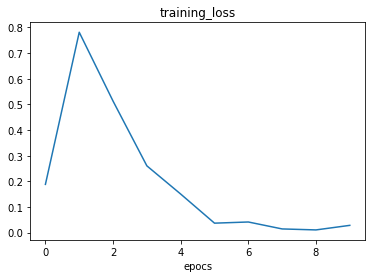

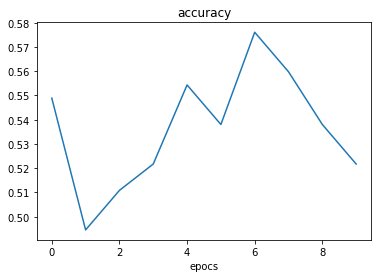

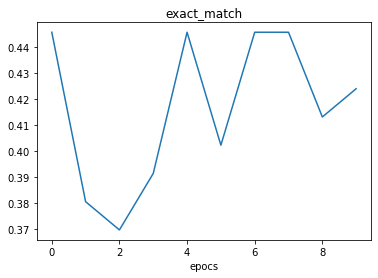

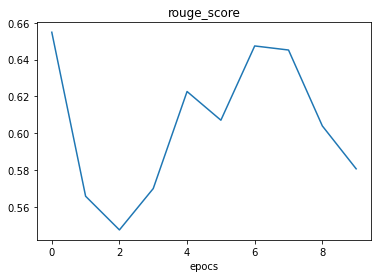

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
for col in model_metrics.columns:
    model_metrics[col].plot(title=col)
    plt.show()

In [15]:
# switch model out of training mode
model.train()
#val_sampler = SequentialSampler(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
acc = []
model_output_truth=[]

# initialize loop for progress bar
loop = tqdm(val_loader)
# loop through batches
for batch in loop:   
    # we don't need to calculate gradients as we're not training
    with torch.no_grad():
        # pull batched items from loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        # make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        # pull preds out
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        # calculate accuracy for both and append to accuracy list
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
        
        reference=ConvertIdstoAnswers(input_ids,start_true,end_true)
        model_output_truth.append([model_out[0],reference[0]])
        break
    break
# calculate average accuracy in total
# acc = sum(acc)/len(acc)/
outputs

  0%|          | 0/92 [00:00<?, ?it/s]<ipython-input-3-762c361fc702>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  0%|          | 0/92 [00:00<?, ?it/s]


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 6.7473e-01, -1.9726e+00, -5.7726e+00, -7.7762e+00, -6.6373e+00,
         -6.0738e+00, -3.4127e+00, -4.2828e+00, -6.1914e+00, -4.3893e+00,
         -8.6943e+00, -6.8612e+00, -7.7571e+00, -4.6834e+00,  9.8037e-01,
         -3.5391e+00, -3.9751e+00, -5.6738e+00, -3.1811e+00, -1.0203e+00,
         -3.9108e+00, -4.2918e+00, -4.7123e+00, -3.5730e+00, -5.6018e+00,
         -5.1846e+00, -3.7684e+00, -3.5536e+00, -5.3733e+00, -3.1196e+00,
         -3.7639e+00, -4.7914e+00, -2.0981e+00, -4.2118e+00,  5.3531e-01,
         -3.5523e+00, -3.3816e+00, -5.2873e+00, -3.9383e+00, -4.5873e+00,
         -3.8021e+00, -5.7235e+00, -8.0699e-01, -2.1455e+00, -2.6225e+00,
         -3.2646e+00, -9.1116e-01, -2.3030e+00, -2.0700e+00, -2.7884e+00,
         -4.3394e+00, -1.7873e+00, -3.5672e+00, -2.1059e+00, -4.0196e+00,
         -3.4722e+00, -6.2228e+00, -4.6558e+00, -2.5603e+00,  1.1748e+00,
          2.9930e-01, -1.7789e+00, -5.6139e+00, -2.7210e+00

In [18]:
model_output_truth[0:]

[['www . jumeirah . com and click on careers .',
  'our website www . jumeirah . com and click on careers .'],
 ['aed 600 without alcoholic beverage .',
  'aed 600 without alcoholic beverage .'],
 ['mundo located in the lobby level', 'mundo'],
 ['within an hour ,', 'within an hour ,'],
 ['None', 'certainly .'],
 ['concierge desk', 'concierge desk'],
 ['https : / / www . jumeirah . com', 'https : / / www . jumeirah . com'],
 ['visa , mastercard , jcb , american express , diners club and union pay cards .',
  'certainly .'],
 ['lockers', 'lockers'],
 ['6am till 11 : 30am', '6am till 11 : 30am'],
 ['14 : 30 to 17 : 00 daily .', '14 : 30 to 17 : 00 daily .'],
 ['visa , mastercard , jcb , american express , diners club and union pay cards .',
  'visa , mastercard , jcb , american express , diners club and union pay cards .'],
 ['concierge desk will be delighted to assist you .',
  'request to our concierge team'],
 ['10am - 12pm on the following day .', '10am - 12pm on the following day .']

In [13]:

# model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
# reference=ConvertIdstoAnswers(input_ids,start_true,end_true)
# print('\nModel output{}'.format(model_out))
# print('\nReference {}'.format(reference))

print("\nThe accuracy of start and end tokens with respect to true position: {}".format(acc))
print("\nRouge Evaulation: {}".format(compute_rouge_evaulation(model_output_truth[0][0],model_output_truth[0][1])))
print("\nExact Match: {}".format(compute_exact_match(model_output_truth[0][0],model_output_truth[0][1])))


The accuracy of start and end tokens with respect to true position: []

Rouge Evaulation: {'rouge-1': {'r': 0.7777777777777778, 'p': 1.0, 'f': 0.8749999950781251}, 'rouge-2': {'r': 0.75, 'p': 1.0, 'f': 0.8571428522448981}, 'rouge-l': {'r': 0.7777777777777778, 'p': 1.0, 'f': 0.8749999950781251}}

Exact Match: 0.13953488372093023


In [29]:
model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
reference=ConvertIdstoAnswers(input_ids,start_true,end_true)

In [20]:
len(input_ids)
for i in range(len(input_ids)):
    

1

In [13]:
def ConvertIdstoQueryAnswer(inputIds,startId,endId):
    answer=''
    results=[]
    for i in range(len(inputIds)):
        token=tokenizer.convert_ids_to_tokens(inputIds[i])      
        if endId[i] >= startId[i]:
            answer = token[startId[i]]
            for i in range(startId[i]+1, endId[i]+1):
                if token[i][0:2] == "##":               
                    answer += token[i][2:]                    
                else:
                    answer += " " + token[i]          
            results.append(answer)   
        else:
            results.append("None")  

    return results

In [16]:
import torch
from transformers import BertTokenizerFast, BertForQuestionAnswering

tokenizer = BertTokenizerFast.from_pretrained(
    "deepset/bert-large-uncased-whole-word-masking-squad2"
)
model = BertForQuestionAnswering.from_pretrained(
    "deepset/bert-large-uncased-whole-word-masking-squad2"
)

query_context=['Laundry opens at 7AM in the morning']
query_question=['what time does the laundry opens?']
query_encodings = tokenizer(query_context, query_question,
                            truncation=True, max_length=171,
                            padding='max_length',return_tensors='pt')

#print(query_encodings)
device="cuda"
input_ids = query_encodings['input_ids'].to(device)
attention_mask = query_encodings['attention_mask'].to(device)
# start_true = query_encodings['start_positions'].to(device)
# end_true = query_encodings['end_positions'].to(device)
model.to(device)
model.eval()
# make predictions
outputs = model(input_ids, attention_mask=attention_mask)
# pull preds out
start_pred = torch.argmax(outputs['start_logits'], dim=1)
end_pred = torch.argmax(outputs['end_logits'], dim=1)
print(start_pred," ",end_pred)
model_out=ConvertIdstoQueryAnswer(input_ids,start_pred,end_pred)
print(model_out[0])


tensor([4], device='cuda:0')   tensor([5], device='cuda:0')
7am


In [ ]:
import torch
from transformers import BertTokenizerFast, BertForQuestionAnswering

device="cuda"

def init(modelPath,tokenizerPath):
    global model
    global tokenizer
    tokenizer = BertTokenizerFast.from_pretrained(modelPath)    
    model = BertForQuestionAnswering.from_pretrained(tokenizerPath)
    model.to(device)
    model.eval()

def getAnswer(question,context):
    query_context=[context]
    query_question=[question]
    query_encodings = tokenizer(query_context, query_question,
                                truncation=True, max_length=171,
                                padding='max_length',return_tensors='pt')

    
    
    input_ids = query_encodings['input_ids'].to(device)
    attention_mask = query_encodings['attention_mask'].to(device)   
    
    # make predictions
    outputs = model(input_ids, attention_mask=attention_mask)
    # pull preds out
    start_pred = torch.argmax(outputs['start_logits'], dim=1)
    end_pred = torch.argmax(outputs['end_logits'], dim=1)
    
    model_out=ConvertIdstoQueryAnswer(input_ids,start_pred,end_pred)
    return model_out[0]
    
   
    

    

In [17]:
# start_scores = (outputs.start_logits[0].unsqueeze(0).cuda()).cpu()
# end_scores = (outputs.end_logits[0].unsqueeze(0).cuda()).cpu()

start_scores = outputs.start_logits[0].clone().detach().cpu().numpy().flatten()
end_scores = outputs.end_logits[0].clone().detach().cpu().numpy().flatten()


tokens=tokenizer.convert_ids_to_tokens(input_ids[0])

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

In [18]:
print(token_labels)

['[CLS]-0', 'laundry-1', 'opens-2', 'at-3', '7-4', '##am-5', 'in-6', 'the-7', 'morning-8', '[SEP]-9', 'what-10', 'time-11', 'does-12', 'the-13', 'laundry-14', 'opens-15', '?-16', '[SEP]-17', '[PAD]-18', '[PAD]-19', '[PAD]-20', '[PAD]-21', '[PAD]-22', '[PAD]-23', '[PAD]-24', '[PAD]-25', '[PAD]-26', '[PAD]-27', '[PAD]-28', '[PAD]-29', '[PAD]-30', '[PAD]-31', '[PAD]-32', '[PAD]-33', '[PAD]-34', '[PAD]-35', '[PAD]-36', '[PAD]-37', '[PAD]-38', '[PAD]-39', '[PAD]-40', '[PAD]-41', '[PAD]-42', '[PAD]-43', '[PAD]-44', '[PAD]-45', '[PAD]-46', '[PAD]-47', '[PAD]-48', '[PAD]-49', '[PAD]-50', '[PAD]-51', '[PAD]-52', '[PAD]-53', '[PAD]-54', '[PAD]-55', '[PAD]-56', '[PAD]-57', '[PAD]-58', '[PAD]-59', '[PAD]-60', '[PAD]-61', '[PAD]-62', '[PAD]-63', '[PAD]-64', '[PAD]-65', '[PAD]-66', '[PAD]-67', '[PAD]-68', '[PAD]-69', '[PAD]-70', '[PAD]-71', '[PAD]-72', '[PAD]-73', '[PAD]-74', '[PAD]-75', '[PAD]-76', '[PAD]-77', '[PAD]-78', '[PAD]-79', '[PAD]-80', '[PAD]-81', '[PAD]-82', '[PAD]-83', '[PAD]-84', '[PAD

In [52]:

#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=start_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

AttributeError: 'bool' object has no attribute 'all'

In [47]:
print((outputs.start_logits[0].unsqueeze(0).cuda()).cpu())
print((outputs.end_logits[0].unsqueeze(0).cuda()).cpu())
print(tokenizer.convert_ids_to_tokens(input_ids[0]) )

tensor([[-4.9777, -3.7759, -2.3087, -4.5696, -4.1991, -5.4316, -4.1112, -4.2602,
         -2.0698, -2.2001, -0.5347, -2.9033, -4.0803,  0.8874, -4.7657, -6.5046,
         -3.0359, -4.7495,  5.2121, -3.0544, -3.3535, -1.6945, -4.6285, -5.7376,
         -8.5749, -8.4333, -8.0667, -5.6325, -7.0387, -8.8732, -4.1688, -5.6720,
         -7.5463, -5.7155, -9.8609, -9.8412, -9.8355, -9.8669, -9.8421, -9.7790,
         -9.7356, -9.8172, -9.8615, -9.8425, -9.8234, -9.8275, -9.8426, -9.8537,
         -9.7733, -9.7514, -9.8258, -9.8399, -9.8616, -9.8836, -9.9150, -9.9127,
         -9.9313, -9.8129, -9.7049, -9.7556, -9.7229, -9.7066, -9.6626, -9.6554,
         -9.6767, -9.6690, -9.5354, -9.6034, -9.6839, -9.7341, -9.7233, -9.6990,
         -9.7150, -9.7023, -9.6481, -9.6754, -9.6788, -9.7494, -9.7617, -9.7528,
         -9.7473, -9.7158, -9.7547, -9.8127, -9.7513, -9.7147, -9.7814, -9.7812,
         -9.7438, -9.7114, -9.6326, -9.6549, -9.5872, -9.5818, -9.5535, -9.5585,
         -9.6412, -9.6760, -